In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

import pycocotools.mask as maskUtils
from matplotlib.patches import Rectangle

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
dataDir='..'
dataType='val2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)
# initialize COCO api for instance annotations
coco_inst=COCO(annFile)

# initialize COCO api for person keypoints annotations
# Format: http://cocodataset.org/#format-data
annFile = '{}/annotations/person_keypoints_{}.json'.format(dataDir,dataType)
coco_kps=COCO(annFile)

# initialize COCO api for caption annotations
annFile = '{}/annotations/captions_{}.json'.format(dataDir,dataType)
coco_caps=COCO(annFile)

# initialize COCO STUFF api for caption annotations
annFile = '%s/annotations/stuff_%s.json' % (dataDir, dataType)
coco_stuff = COCO(annFile)

loading annotations into memory...
Done (t=0.62s)
creating index...
index created!
loading annotations into memory...
Done (t=0.43s)
creating index...
index created!
loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
loading annotations into memory...
Done (t=1.22s)
creating index...
index created!


In [3]:
# display COCO **instance** categories and supercategories
cats = coco_inst.loadCats(coco_inst.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))
nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

# Display COCO **stuff** categories and supercategories
categories = coco_stuff.loadCats(coco_stuff.getCatIds())
categoryNames = [cat['name'] for cat in categories]
print 'COCO Stuff leaf categories: \n', ' '.join(categoryNames)
superCategoryNames = sorted(set([cat['supercategory'] for cat in categories]))
print 'COCO Stuff super categories: \n', ' '.join(superCategoryNames)

COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

COCO supercategories: 
outdoor food indoor appliance sports person animal vehicle furniture accessory electronic kitchen
COCO Stuff leaf categories: 
banner blanket branch bridge building-other bush cabinet cage cardboard carpet ceiling-other ceiling-tile cloth clothes clouds counter cupboard curtain desk-stuff dirt door-stuff fence floor-marble floor-other 

# Get all valid/clear persons

In [ ]:
import imageio

# get all images containing given categories, select one at random
catIds = coco_inst.getCatIds(catNms=['person']);
imgIds = coco_inst.getImgIds(catIds=catIds );
print(len(imgIds))
# imgIds = coco.getImgIds(imgIds = [324158])

count_total_obj = 0
size_list = []
for ImgIdx, imgID in enumerate(imgIds):
    img = coco_inst.loadImgs(imgID)[0]

    # load and display instance annotations
    annIds = coco_inst.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
    anns = coco_inst.loadAnns(annIds)
#     coco.showAnns(anns)
    anns_kps = coco_kps.loadAnns(annIds)
    anns_caps = coco_caps.loadAnns(coco_caps.getAnnIds(imgIds=img['id']))
    annIds_allCats = coco_inst.getAnnIds(imgIds=img['id'], iscrowd=None)
    anns_allCats = coco_inst.loadAnns(annIds_allCats)
    annIds_stuff = coco_stuff.getAnnIds(imgIds=img['id'])
    anns_stuff = coco_stuff.loadAnns(annIds_stuff)

    any_clear = False
    num_clear = 0
    for idx in range(len(anns)):
        ## Get kps
        ann_kps = anns_kps[idx]
        if_clear = check_clear(ann_kps)
        
        if if_clear:
            any_clear = True
            num_clear += 1
    
    if any_clear == False:
        continue
#     if num_clear < 3:
#         continue
    
    ## load and display image
    # I = io.imread('%s/images/%s/%s'%(dataDir,dataType,img['file_name']))
    # use url to load image
    I = io.imread(img['coco_url'])
#     plt.figure(figsize=(10, 10))
#     plt.figure(figsize=(30, 40))
#     plt.subplot(121)
#     plt.title('%s'%ImgIdx)
# #     plt.imshow(I); plt.axis('off')
#     plt.imshow(I); plt.axis('off')
        
    for idx in range(len(anns)):
        ann = anns[idx]
        
        ## Get bbox
        mask1 = ann['segmentation']
        
        ## Get kps
        ann_kps = anns_kps[idx]
        if_clear = check_clear(ann_kps)
        
        if not if_clear:
            continue

        # https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocotools/coco.py#L265
        rle = maskUtils.frPyObjects(mask1, img['height'], img['width'])
    #     print(rle)
        area = maskUtils.area(rle)

        bboxes = maskUtils.toBbox(rle) # [x, y, w, h]
        if len(bboxes.shape)!=2:
            print('Warning!! len(bboxes.shape)!=2')
            continue
                
        bbox_merged = bboxes[0] if len(bboxes)==1 else merge_bboxes(bboxes)
        obj_patch = I[int(bbox_merged[1]):(int(bbox_merged[1])+int(bbox_merged[3])), \
                      int(bbox_merged[0]):(int(bbox_merged[0])+int(bbox_merged[2]))]
#         plt.figure()
#         plt.imshow(obj_patch)
#         plt.show()
        
        imageio.imwrite('~/Documents/Results/vis/%d.jpg'%count_total_obj, obj_patch)
        count_total_obj += 1
        
        size_list.append([int(bbox_merged[2]), int(bbox_merged[3])])

In [11]:
len(imgIds)

2693

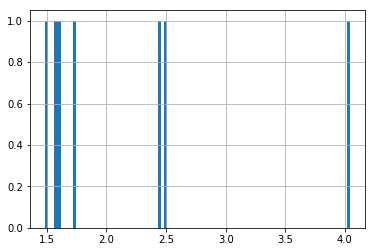

In [12]:
size_array = np.asarray(size_list)
ratio_array = size_array[:, 1].astype(np.float) / size_array[:, 0].astype(np.float) # height to width

plt.figure()
plt.hist(ratio_array, 100)
plt.grid()
plt.show()

In [405]:
ratio_array_sort_idx = np.argsort(ratio_array)
ratio_array_sorted = ratio_array[ratio_array_sort_idx]
ratio_mask = (ratio_array_sorted > 0.) & (ratio_array_sorted < 8.)

img_idx = np.asarray(range(ratio_array.shape[0]))[ratio_array_sort_idx]
img_idx_masked = img_idx[ratio_mask]

for idx, img_idx in enumerate(img_idx_masked[:100]):
    img = imageio.imread('~/Documents/Results/vis/%d.jpg'%img_idx)
    plt.imshow(img)
    plt.show()
    print(idx, ratio_array_sorted[ratio_mask][idx])

OSError: No such file: '/Users/ruzhu/Documents/Results/vis/127.jpg'

# Get imgs with valid persons in correct ratio and >3 number

In [ ]:
import imageio

# get all images containing given categories, select one at random
catIds = coco_inst.getCatIds(catNms=['person']);
imgIds = coco_inst.getImgIds(catIds=catIds );
# print(imgIds)
# imgIds = coco.getImgIds(imgIds = [324158])

count_total_obj = 0
size_list = []
for ImgIdx, imgID in enumerate(imgIds):
    img = coco_inst.loadImgs(imgID)[0]

    # load and display instance annotations
    annIds = coco_inst.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
    anns = coco_inst.loadAnns(annIds)
#     coco.showAnns(anns)
    anns_kps = coco_kps.loadAnns(annIds)
    anns_caps = coco_caps.loadAnns(coco_caps.getAnnIds(imgIds=img['id']))
    annIds_allCats = coco_inst.getAnnIds(imgIds=img['id'], iscrowd=None)
    anns_allCats = coco_inst.loadAnns(annIds_allCats)
    annIds_stuff = coco_stuff.getAnnIds(imgIds=img['id'])
    anns_stuff = coco_stuff.loadAnns(annIds_stuff)

    any_clear = False
    num_clear = 0
    num_valid = 0
    bbox_merged_list = []
    if_clear_list = []
    ratio_list = []
    for idx in range(len(anns)):
        ## Get kps
        ann_kps = anns_kps[idx]
        if_clear = check_clear(ann_kps) # check for head up and foot down person
        
        ## Get bbox
        ann = anns[idx]
        mask1 = ann['segmentation']
        # https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocotools/coco.py#L265
        rle = maskUtils.frPyObjects(mask1, img['height'], img['width'])
        area = maskUtils.area(rle)
        bboxes = maskUtils.toBbox(rle) # [x, y, w, h]
        if len(bboxes.shape)!=2:
#             print('Warning!! len(bboxes.shape)!=2')
            continue     
        bbox_merged = bboxes[0] if len(bboxes)==1 else merge_bboxes(bboxes)
        
        ratio = float(bbox_merged[3]) / float(bbox_merged[2])
#         if ratio <= 2.:
#             continue
        
        if if_clear:
            any_clear = True
            num_clear += 1
#             if ratio > 2. and ratio < 8.:
            num_valid += 1
        bbox_merged_list.append(bbox_merged)
        if_clear_list.append(if_clear)
        ratio_list.append(ratio)
    
    if any_clear == False:
        continue
    if num_valid < 2:
        continue
    
    ## load and display image
    # I = io.imread('%s/images/%s/%s'%(dataDir,dataType,img['file_name']))
    # use url to load image
    I = io.imread(img['coco_url'])
#     plt.figure(figsize=(10, 10))
    plt.figure(figsize=(30, 40))
    plt.subplot(121)
    plt.title('%s'%ImgIdx)
# #     plt.imshow(I); plt.axis('off')
    plt.imshow(I); 
#     plt.axis('off')
        
    coco_kps.showAnns(anns_kps)
    coco_caps.showAnns(anns_caps)
    coco_inst.showAnns(anns_allCats)
    
    plt.subplot(122)
    plt.imshow(I); plt.axis('off')
    stuff_id_map = np.zeros((I.shape[0], I.shape[1]), dtype=np.int)
    for ann in anns_stuff:
        color = coco_stuff.showAnns([ann])
        cat = categories[ann['category_id']-92]['name']
        cat_sup = categories[ann['category_id']-92]['supercategory']
        if cat_sup != 'other':
            bbox = ann['bbox']
            plt.text(bbox[0]+bbox[2]/2., bbox[1]+bbox[3]/2., '%s/%s'%(cat_sup, cat), 
                 fontsize=12, color='w', bbox=dict(facecolor=color[0], alpha=0.5, edgecolor='w'))
            
        mask = maskUtils.decode(ann['segmentation'])
        stuff_id_map += mask * (ann['category_id']-92)
        
    plt.subplot(121)
    ax = plt.gca()
    H, W = I.shape[0], I.shape[1]
    for bbox_merged, if_clear, ratio in zip(bbox_merged_list, if_clear_list, ratio_list):
        if not if_clear:
            continue
        if_valid = if_clear
        if_ratio = ratio > 2. and ratio < 8.
        if_valid = if_clear and if_ratio
        
        rect = Rectangle((bbox_merged[0], bbox_merged[1]), bbox_merged[2], bbox_merged[3], linewidth=2, edgecolor='lime' if if_valid else 'r', facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)
        plt.text(bbox_merged[0], bbox_merged[1]-12, '%.2f'%ratio, 
                 fontsize=12, bbox=dict(facecolor='lime' if if_valid else 'red', alpha=0.5))
        
        lower_left = [np.clip(int(bbox_merged[0]), 0, W-1), np.clip(int(bbox_merged[1]+bbox_merged[3]), 0, H-1)]
        lower_right = [np.clip(int(bbox_merged[0]+bbox_merged[2]), 0, W-1), np.clip(int(bbox_merged[1]+bbox_merged[3]), 0, H-1)]
        lower_left_id = stuff_id_map[lower_left[1], lower_left[0]]
        lower_left_id_subs = [categories[lower_left_id]['supercategory'], categories[lower_left_id]['name']] if lower_left_id!=0 else ['null', 'null']
        lower_right_id = stuff_id_map[lower_right[1], lower_right[0]]
        lower_right_id_subs = [categories[lower_right_id]['supercategory'], categories[lower_right_id]['name']] if lower_right_id!=0 else ['null', 'null']
        if_valid_surface = check_valid_surface(lower_left_id_subs) or check_valid_surface(lower_right_id_subs)

        plt.text(bbox_merged[0], bbox_merged[1]+bbox_merged[3]+6, '%s/%s'%(lower_left_id_subs[0], lower_left_id_subs[1]),  
                 fontsize=12, bbox=dict(facecolor='lime' if if_valid_surface else 'red', alpha=0.5))
        plt.text(bbox_merged[0], bbox_merged[1]+bbox_merged[3]+18, '%s/%s'%(lower_right_id_subs[0], lower_right_id_subs[1]),  
                 fontsize=12, bbox=dict(facecolor='lime' if if_valid_surface else 'red', alpha=0.5))
        
        
    
    plt.show()

# For single image

A baseball team playing a baseball game in front of a crowd.
The batter stands at the plate ready to swing, as the players stand ready in the outfield.
A baseball game with a bunch of people in the stands. 
baseball players getting paid to play a game
A baseball player preparing to bat during a game.


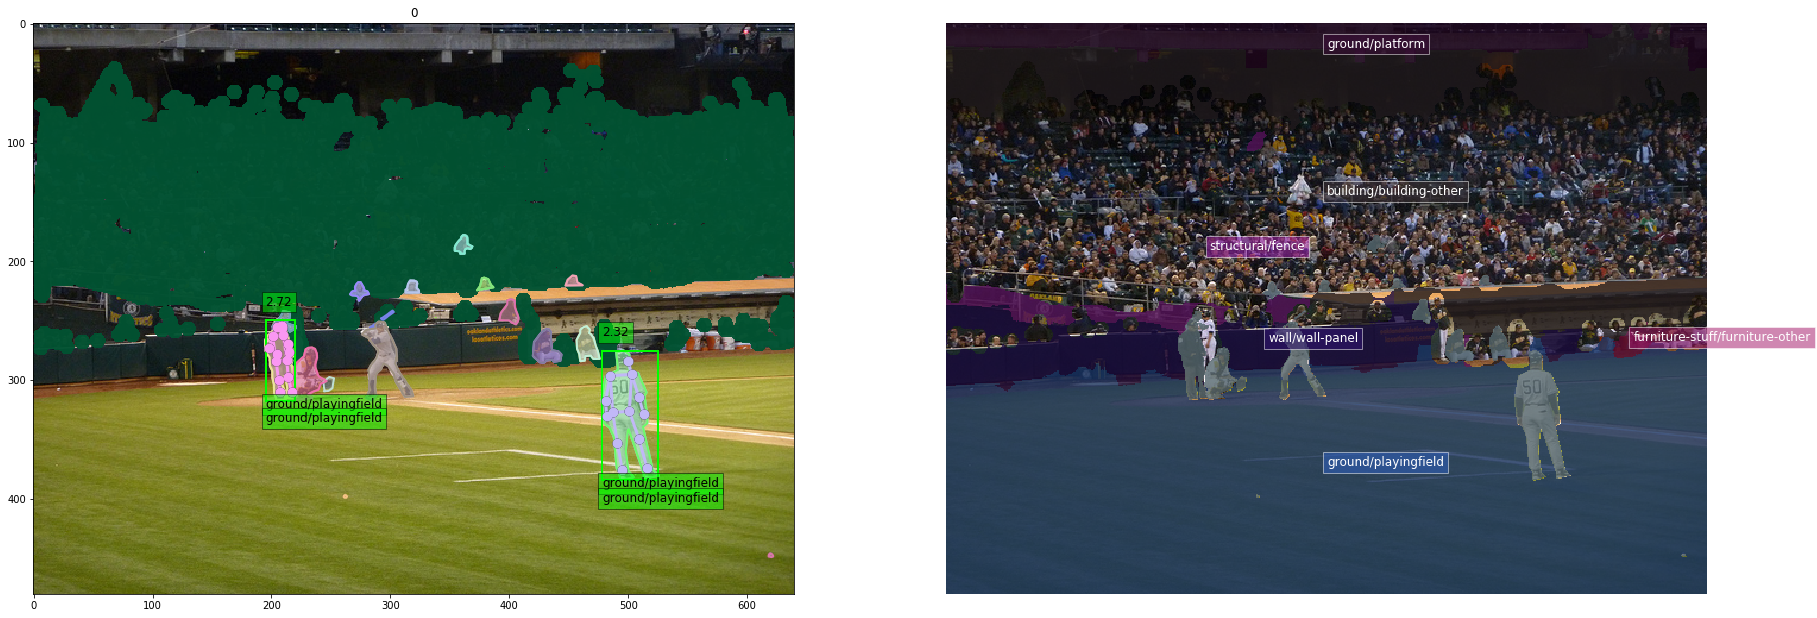

In [274]:
import imageio

# get all images containing given categories, select one at random
catIds = coco_inst.getCatIds(catNms=['person']);
imgIds = coco_inst.getImgIds(catIds=catIds );
# print(imgIds)
# imgIds = coco.getImgIds(imgIds = [324158])

count_total_obj = 0
size_list = []
# for ImgIdx, imgID in enumerate(imgIds):
ImgIdx = 0
img_select = 87
imgID = imgIds[img_select]

img = coco_inst.loadImgs(imgID)[0]

# load and display instance annotations
annIds = coco_inst.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco_inst.loadAnns(annIds)
#     coco.showAnns(anns)
anns_kps = coco_kps.loadAnns(annIds)
anns_caps = coco_caps.loadAnns(coco_caps.getAnnIds(imgIds=img['id']))
annIds_allCats = coco_inst.getAnnIds(imgIds=img['id'], iscrowd=None)
anns_allCats = coco_inst.loadAnns(annIds_allCats)
annIds_stuff = coco_stuff.getAnnIds(imgIds=img['id'])
anns_stuff = coco_stuff.loadAnns(annIds_stuff)

any_clear = False
num_clear = 0
num_valid = 0
bbox_merged_list = []
if_clear_list = []
ratio_list = []
for idx in range(len(anns)):
    ## Get kps
    ann_kps = anns_kps[idx]
    if_clear = check_clear(ann_kps) # check for head up and foot down person

    ## Get bbox
    ann = anns[idx]
    mask1 = ann['segmentation']
    # https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocotools/coco.py#L265
    rle = maskUtils.frPyObjects(mask1, img['height'], img['width'])
    area = maskUtils.area(rle)
    bboxes = maskUtils.toBbox(rle) # [x, y, w, h]
    if len(bboxes.shape)!=2:
#             print('Warning!! len(bboxes.shape)!=2')
        continue     
    bbox_merged = bboxes[0] if len(bboxes)==1 else merge_bboxes(bboxes)

    ratio = float(bbox_merged[3]) / float(bbox_merged[2])
#         if ratio <= 2.:
#             continue

    if if_clear:
        any_clear = True
        num_clear += 1
        if ratio > 2. and ratio < 8.:
            num_valid += 1
    bbox_merged_list.append(bbox_merged)
    if_clear_list.append(if_clear)
    ratio_list.append(ratio)

# if any_clear == False:
#     continue
# if num_valid < 2:
#     continue

## load and display image
# I = io.imread('%s/images/%s/%s'%(dataDir,dataType,img['file_name']))
# use url to load image
I = io.imread(img['coco_url'])
#     plt.figure(figsize=(10, 10))
plt.figure(figsize=(30, 40))
plt.subplot(121)
plt.title('%s'%ImgIdx)
# #     plt.imshow(I); plt.axis('off')
plt.imshow(I); 
#     plt.axis('off')

coco_kps.showAnns(anns_kps)
coco_caps.showAnns(anns_caps)
coco_inst.showAnns(anns_allCats)

plt.subplot(122)
plt.imshow(I); plt.axis('off')
stuff_id_map = np.zeros((I.shape[0], I.shape[1]), dtype=np.int)
for ann in anns_stuff:
    color = coco_stuff.showAnns([ann])
    cat = categories[ann['category_id']-92]['name']
    cat_sup = categories[ann['category_id']-92]['supercategory']
    if cat_sup != 'other':
        bbox = ann['bbox']
        plt.text(bbox[0]+bbox[2]/2., bbox[1]+bbox[3]/2., '%s/%s'%(cat_sup, cat), 
             fontsize=12, color='w', bbox=dict(facecolor=color[0], alpha=0.5, edgecolor='w'))

    mask = maskUtils.decode(ann['segmentation'])
    stuff_id_map += mask * (ann['category_id']-92)

plt.subplot(121)
ax = plt.gca()
H, W = I.shape[0], I.shape[1]
for bbox_merged, if_clear, ratio in zip(bbox_merged_list, if_clear_list, ratio_list):
    if not if_clear:
        continue
    if_valid = if_clear
#     if_ratio = ratio > 2. and ratio < 8.
#     if_valid = if_clear and if_ratio

    rect = Rectangle((bbox_merged[0], bbox_merged[1]), bbox_merged[2], bbox_merged[3], linewidth=2, edgecolor='lime' if if_valid else 'r', facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
    plt.text(bbox_merged[0], bbox_merged[1]-12, '%.2f'%ratio, 
             fontsize=12, bbox=dict(facecolor='lime' if if_valid else 'red', alpha=0.5))

    lower_left = [np.clip(int(bbox_merged[0]), 0, W-1), np.clip(int(bbox_merged[1]+bbox_merged[3]), 0, H-1)]
    lower_right = [np.clip(int(bbox_merged[0]+bbox_merged[2]), 0, W-1), np.clip(int(bbox_merged[1]+bbox_merged[3]), 0, H-1)]
    lower_left_id = stuff_id_map[lower_left[1], lower_left[0]]
    lower_left_id_subs = [categories[lower_left_id]['supercategory'], categories[lower_left_id]['name']] if lower_left_id!=0 else ['null', 'null']
    lower_right_id = stuff_id_map[lower_right[1], lower_right[0]]
    lower_right_id_subs = [categories[lower_right_id]['supercategory'], categories[lower_right_id]['name']] if lower_right_id!=0 else ['null', 'null']
    if_valid_surface = check_valid_surface(lower_left_id_subs) or check_valid_surface(lower_right_id_subs)

    plt.text(bbox_merged[0], bbox_merged[1]+bbox_merged[3]+6, '%s/%s'%(lower_left_id_subs[0], lower_left_id_subs[1]),  
             fontsize=12, bbox=dict(facecolor='lime' if if_valid_surface else 'red', alpha=0.5))
    plt.text(bbox_merged[0], bbox_merged[1]+bbox_merged[3]+18, '%s/%s'%(lower_right_id_subs[0], lower_right_id_subs[1]),  
             fontsize=12, bbox=dict(facecolor='lime' if if_valid_surface else 'red', alpha=0.5))

plt.show()

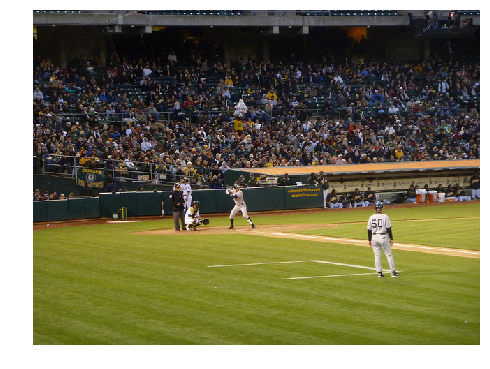

http://images.cocodataset.org/val2017/000000065798.jpg


In [275]:
plt.imshow(I)
plt.axis('off')
plt.show()

print(img['coco_url'])

{'debug_filename': array([u'000000065798.jpg'], dtype='<U16'), 'vfov': array([[0.35978346]]), '__globals__': [], 'horizon_visible': array([[1]], dtype=uint8), '__header__': 'MATLAB 5.0 MAT-file Platform: posix, Created on: Thu Aug 29 00:50:00 2019', 'pitch': array([[0.58854167]]), 'distortion': array([[0.03740157]]), '__version__': '1.0', 'roll': array([[0.00155486]])}


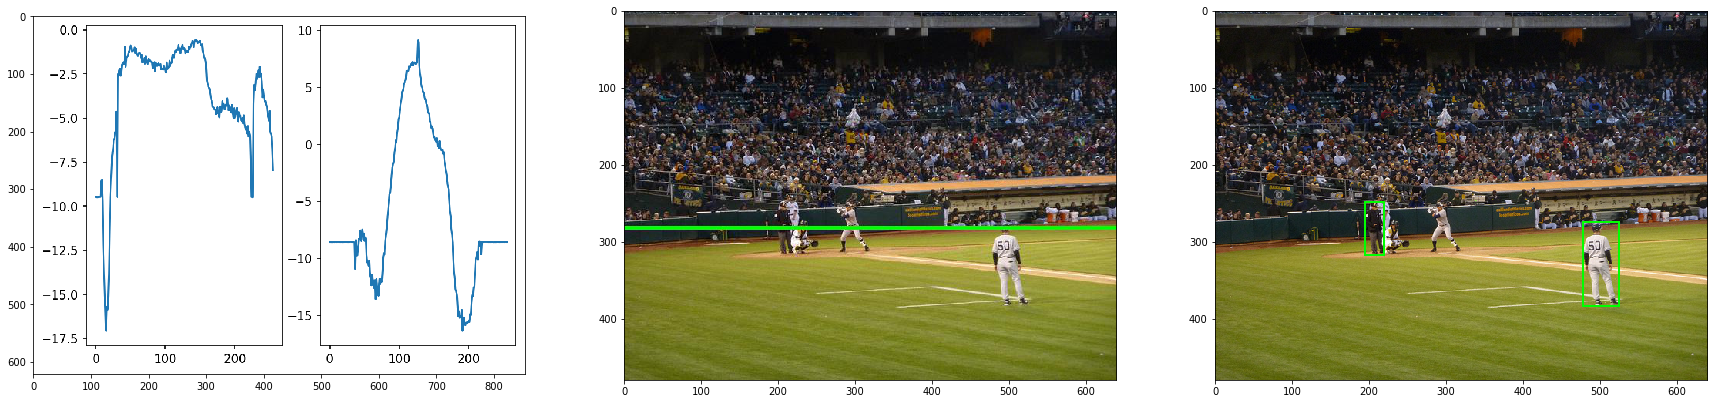

In [276]:
yannick_path = '../../{}_yannick_results'.format(dataType)
img_name = img['coco_url'].split('/')[-1].encode("ascii")
yannick_file = yannick_path + '/nn_output_--debug_' + img_name + '/%s_output.mat'%img_name.replace('.jpg', '')
yannick_conf = yannick_path + '/nn_output_--debug_' + img_name + '/%s_prob.png'%img_name.replace('.jpg', '')
yannick_vis = yannick_path + '/nn_output_--debug_' + img_name + '/%s.jpg'%img_name.replace('.jpg', '')

from scipy.io import loadmat
yannick_results = loadmat(yannick_file)
print(yannick_results)

plt.figure(figsize=(30, 20))
plt.subplot(131)
plt.imshow(plt.imread(yannick_conf))
plt.subplot(132)
plt.imshow(plt.imread(yannick_vis))
plt.subplot(133)
ax = plt.gca()
plt.imshow(I)

bbox_good_list = []
for bbox_merged, if_clear, ratio in zip(bbox_merged_list, if_clear_list, ratio_list):
    # bbox_merged: [x, y, w, h]
    if not if_clear:
        continue
    if_valid = if_clear
    if_ratio = ratio > 2. and ratio < 8.
    if_valid = if_clear and if_ratio
    
    if not if_valid:
        continue
        
    rect = Rectangle((bbox_merged[0], bbox_merged[1]), bbox_merged[2], bbox_merged[3], linewidth=2, edgecolor='lime' if if_valid else 'r', facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
    
    bbox_good_list.append(bbox_merged)

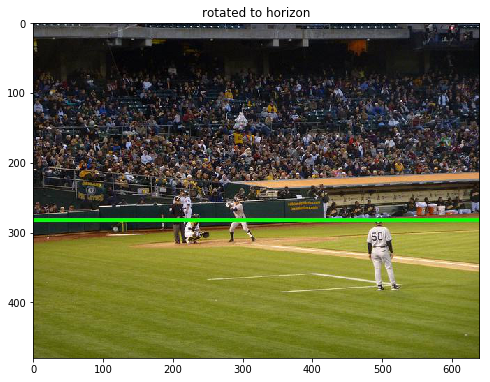

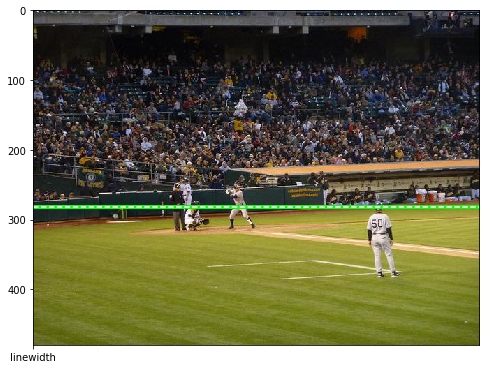

In [277]:
roll = yannick_results['roll'][0][0]
from PIL import Image
colorImage  = Image.open(yannick_vis)
rotated = colorImage.rotate(roll/np.pi*180.)
plt.imshow(rotated)
plt.title('rotated to horizon')
plt.show()

horizon_visible = yannick_results['horizon_visible'][0][0]
if horizon_visible:
    horizon = yannick_results['pitch'][0][0] # The second parameter represents the camera pitch and depends on the first estimation. If horizon was visible in this image, it is the position of the horizon in the center of the image (0 = top of the image, 1 = bottom of the image). If the horizon was not visible in this image, this value is the pitch angle of the camera in radians. 
else:
    pitch = yannick_results['pitch'][0][0]
    
assert horizon_visible==1, 'Horizon not visible!'

H, W = I.shape[0], I.shape[1]
horizon_pixels_yannick = H * horizon
plt.figure()
plt.imshow(rotated)
plt.plot([0., W-1.], [horizon_pixels_yannick, horizon_pixels_yannick], 'w--', 'linewidth', 5)
plt.show()

## Get horizon from each detection

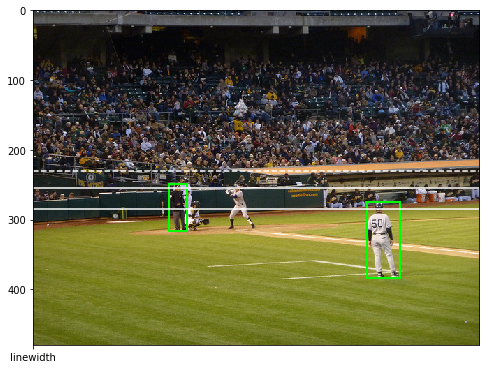

In [280]:
H, W = I.shape[0], I.shape[1]
v0_image = horizon_pixels_yannick
v0_image = 230.
v0 = H - v0_image
y_person = 1.75
yc = 1.6

plt.figure()
ax = plt.gca()
plt.imshow(I)
plt.plot([0., W-1.], [v0_image, v0_image], 'w--', 'linewidth', 5)

for bbox in bbox_good_list:
    rect = Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='lime' if if_valid else 'r', facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
    
    vt = H - bbox[1]
    vb = H - (bbox[1] + bbox[3])
    v0_single = yc * (vt - vb) / y_person + vb
    
    plt.plot([0., W-1.], [H-v0_single, H-v0_single], 'w-', 'linewidth', 2)
    
plt.show()

## Get one camera height from all detections (Derek's further approx.)

2.795795795795796
2.4550724637681163


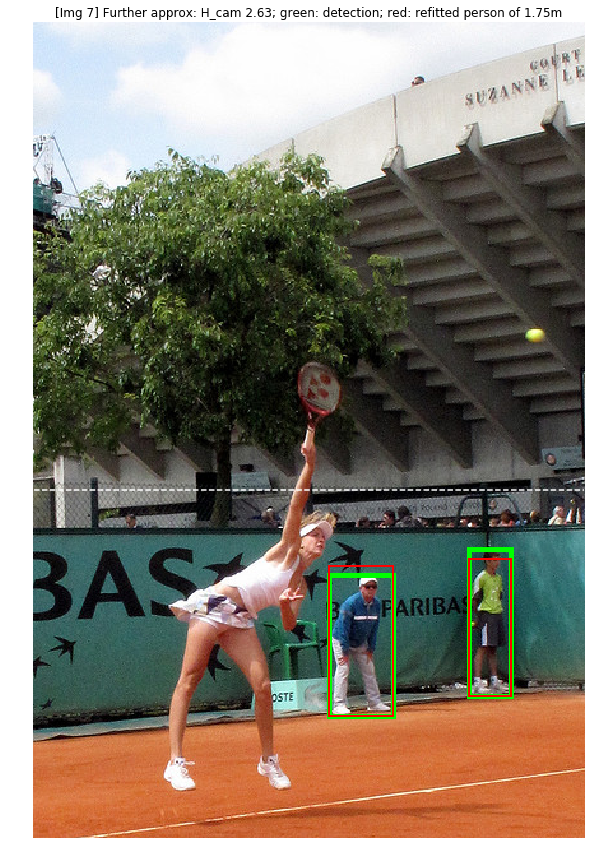

In [258]:
H, W = I.shape[0], I.shape[1]
v0 = H - v0_image
y_person = 1.75
yc = 1.6

plt.figure(figsize=(15, 15))
ax = plt.gca()
plt.imshow(I)
plt.plot([0., W-1.], [v0_image, v0_image], 'w--', 'linewidth', 5)

yc_list = []
for bbox in bbox_good_list:
    vt = H - bbox[1]
    vb = H - (bbox[1] + bbox[3])
#     v0_single = yc * (vt - vb) / y_person + vb
    yc_single = y_person * (v0 - vb) / (vt - vb)
    print(yc_single)
    yc_list.append(yc_single)
    
yc_estCam = np.median(np.asarray(yc_list))
# yc_estCam = np.mean(np.asarray(yc_list))

for bbox in bbox_good_list:
    rect = Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=5, edgecolor='lime', facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
    
#     vt = H - bbox[1]
    vb = H - (bbox[1] + bbox[3])
    vt_camEst = y_person / yc_estCam * (v0 - vb) + vb
    
    rect = Rectangle((bbox[0], H-vt_camEst), bbox[2], bbox[1]+bbox[3]-(H-vt_camEst), linewidth=2, edgecolor='r', facecolor='none')
#     # Add the patch to the Axes
    ax.add_patch(rect)

plt.title('[Img %d] Further approx: H_cam %.2f; green: detection; red: refitted person of 1.75m'%(img_select, yc_estCam))
plt.axis('off')
plt.show()

## Get one camera height and f from all detections (Derek's approx.) (least squares on h_cam and f)

('Cam height: ', 2.795795795795796)
('Cam height: ', 2.4550724637681163)
('median_cam:', 2.625434129781956)
('least square cam:', 1.5670391916291797)
('should_be_zero:', -0.36171367046981523)


/Users/ruzhu/miniconda2/envs/cocoapi_py27/lib/python2.7/site-packages/ipykernel_launcher.py:33: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/ruzhu/miniconda2/envs/cocoapi_py27/lib/python2.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in sqrt


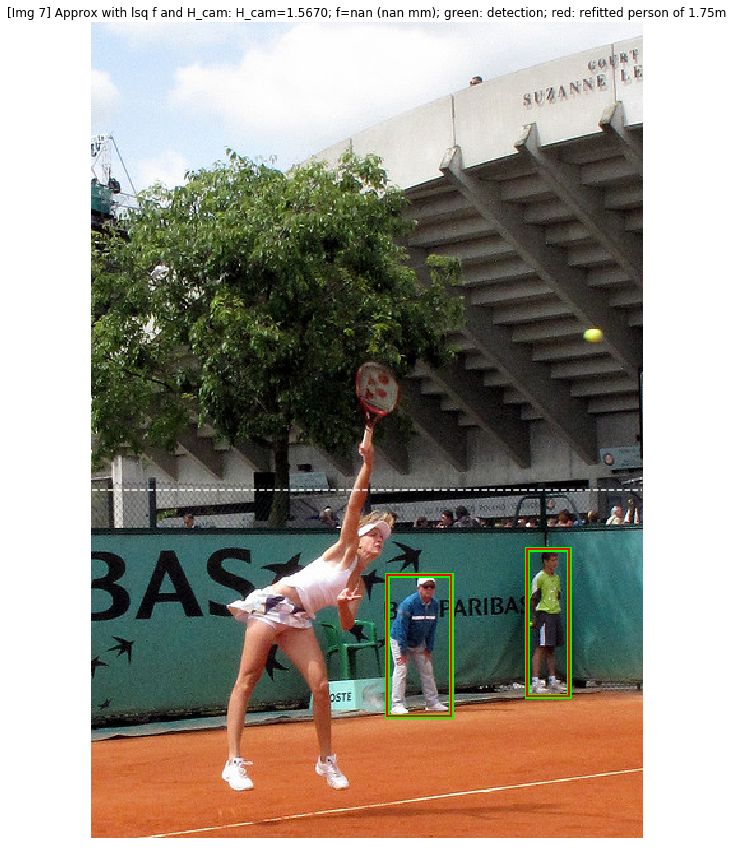

1.5670391916291797
nan


In [259]:
H, W = I.shape[0], I.shape[1]
v0 = H - v0_image
y_person = 1.75
# yc = 1.6
vc = H / 2.

plt.figure(figsize=(15, 15))
ax = plt.gca()
plt.imshow(I)
plt.plot([0., W-1.], [v0_image, v0_image], 'w--', 'linewidth', 5)

yc_list = []
a_list = []
b_list = []
for bbox in bbox_good_list:
    vt = H - bbox[1]
    vb = H - (bbox[1] + bbox[3])
#     v0_single = yc * (vt - vb) / y_person + vb
    yc_single = y_person * (v0 - vb) / (vt - vb)
    print('Cam height: ', yc_single)
    yc_list.append(yc_single)
    
    a = (vt - vb) / (v0 - vb)
    a_list.append(a)
    b = -y_person * (vc - v0) * (vc - vt)
    b_list.append(b)
    
yc_estCam = np.median(np.asarray(yc_list))
print('median_cam:', yc_estCam)
# # yc_estCam = np.mean(np.asarray(yc_list))
A = np.hstack((np.asarray(a_list).reshape((-1, 1)), np.asarray(b_list).reshape((-1, 1))))
b = np.zeros((A.shape[0], 1)) + y_person
x, res, rank, s = np.linalg.lstsq(A, b)
yc_estCam = x[0][0]
print('least square cam:', yc_estCam)
inv_f2 = x[1][0]
f = np.sqrt(1./inv_f2)

should_be_zero = (vc - v0) * (vc - vt) * inv_f2
print('should_be_zero:', should_be_zero)

for bbox in bbox_good_list:
    rect = Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=5, edgecolor='lime', facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
    
#     vt = H - bbox[1]
    vb = H - (bbox[1] + bbox[3])
#     vt_camEst = y_person / yc_estCam * (v0 - vb) + vb
#     print(vt_camEst)
    vt_camEst = (yc_estCam * vb + y_person * (v0 - vb) * (1. + inv_f2 * (vc - v0) * vc)) / \
        (yc_estCam + y_person * (v0 - vb) * inv_f2 * (vc - v0))
    
    rect = Rectangle((bbox[0], H-vt_camEst), bbox[2], bbox[1]+bbox[3]-(H-vt_camEst), linewidth=2, edgecolor='r', facecolor='none')
#     # Add the patch to the Axes
    ax.add_patch(rect)

plt.title('[Img %d] Approx with lsq f and H_cam: H_cam=%.4f; f=%.2f (%.2f mm); green: detection; red: refitted person of 1.75m'%(img_select, yc_estCam, f, f_to_mm(f, H, W)))

plt.axis('off')
plt.show()

print(yc_estCam)
print(f)

In [252]:
vfov_est = 2. * np.arctan(H / 2. / f)
print(vfov_est/np.pi*180.)

theta_est = 2 * np.arctan((vc - v0) / 2. / f)
print(theta_est/np.pi*180.)

164.351637772172
-17.242048928782673


## Use Yannick's f; get one cam height from all detections (median)

theta should be: -0.007577; theta approx by Derek: -0.007577
('Cam height: ', 2.472974032194092)
('Cam height: ', 2.239086293772479)
('median_cam:', 2.3560301629832856)
('should_be_zero:', -5.1675336277619956e-05)


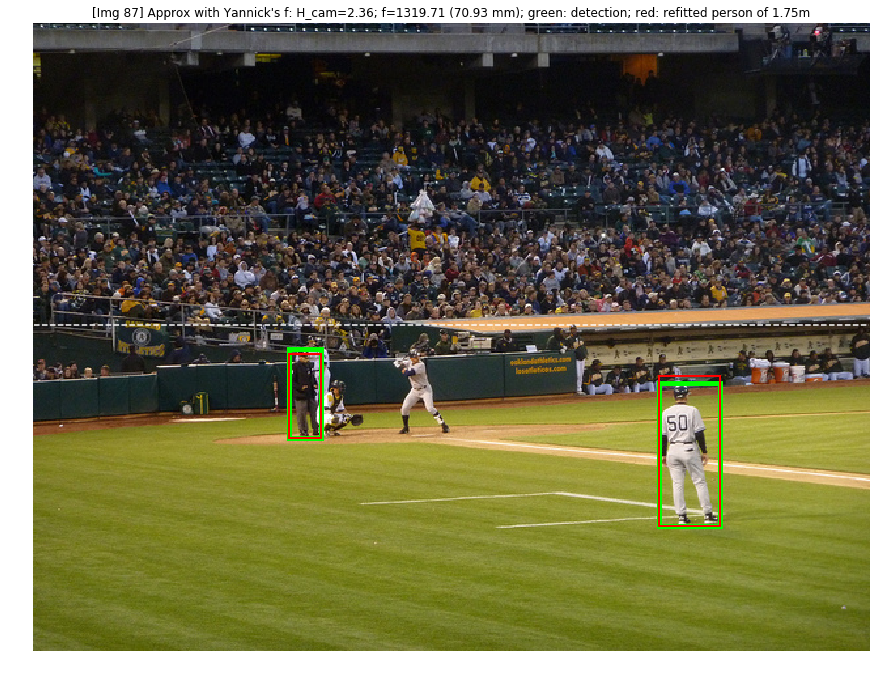

In [281]:
vfov = yannick_results['vfov'][0][0]
f_pixels_yannick = H/2./(np.tan(vfov/2.))

# f_pixels_yannick = fmm_to_fpix(50, H, W)

theta = (vc - v0) / f
theta_should = 2 * np.arctan((vc - v0) / (2. * f_pixels_yannick))
print('theta should be: %f; theta approx by Derek: %f'%(theta_should, theta))

inv_f2_yannick = 1./ (f_pixels_yannick * f_pixels_yannick)
# should_be_zero_yannick = (vc - v0) * (vc - vt) * inv_f2_yannick
# print('should_be_zero_yannick: %f'%should_be_zero_yannick)

H, W = I.shape[0], I.shape[1]
v0 = H - v0_image
y_person = 1.75
# yc = 1.6
vc = H / 2.

plt.figure(figsize=(15, 15))
ax = plt.gca()
plt.imshow(I)
plt.plot([0., W-1.], [v0_image, v0_image], 'w--', 'linewidth', 5)

yc_list = []
a_list = []
b_list = []
for bbox in bbox_good_list:
    vt = H - bbox[1]
    vb = H - (bbox[1] + bbox[3])
#     v0_single = yc * (vt - vb) / y_person + vb
    yc_single = y_person * (v0 - vb) / (vt - vb) / (1. + (vc - v0) * (vc - vt) / f_pixels_yannick**2)
    print('Cam height: ', yc_single)
    yc_list.append(yc_single)
    
    a = (vt - vb) / (v0 - vb)
    a_list.append(a)
    b = -y_person * (vc - v0) * (vc - vt)
    b_list.append(b)
    
yc_estCam = np.median(np.asarray(yc_list))
print('median_cam:', yc_estCam)
inv_f2 = 1. / (f_pixels_yannick*f_pixels_yannick)
f = f_pixels_yannick

should_be_zero = (vc - v0) * (vc - vt) * inv_f2
print('should_be_zero:', should_be_zero)

for bbox in bbox_good_list:
    rect = Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=5, edgecolor='lime', facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
    
#     vt = H - bbox[1]
    vb = H - (bbox[1] + bbox[3])
#     vt_camEst = y_person / yc_estCam * (v0 - vb) + vb
#     print(vt_camEst)
    vt_camEst = (yc_estCam * vb + y_person * (v0 - vb) * (1. + inv_f2 * (vc - v0) * vc)) / \
        (yc_estCam + y_person * (v0 - vb) * inv_f2 * (vc - v0))
    
    rect = Rectangle((bbox[0], H-vt_camEst), bbox[2], bbox[1]+bbox[3]-(H-vt_camEst), linewidth=2, edgecolor='r', facecolor='none')
#     # Add the patch to the Axes
    ax.add_patch(rect)

plt.title('[Img %d] Approx with Yannick\'s f: H_cam=%.2f; f=%.2f (%.2f mm); green: detection; red: refitted person of 1.75m'%(img_select, yc_estCam, f, f_to_mm(f, H, W)))
plt.axis('off')
plt.show()

In [282]:
print(vfov/np.pi*180.)

# vfov = yannick_results['vfov'][0][0]
# f_pixels_yannick = H/2./(np.tan(vfov/2.))

print(theta_should/np.pi*180.)

20.614074058279638
-0.43415114971214563


In [283]:
v_fov_fake = 99.
f_pixels_fake = H/2./(np.tan(v_fov_fake/180.*np.pi/2.))
print(f_pixels_fake)

204.97936451123198


In [284]:
print(H, W)

(480, 640)


# No approx; using Yannick's pitch and f

theta should be: -0.013567; theta approx by Derek: -0.013568
('Cam height: ', 1.7903386133097603)
('Cam height: ', 1.8352872951459414)
('median_cam:', 1.8128129542278508)
('should_be_zero:', 0.0002024857817759966)


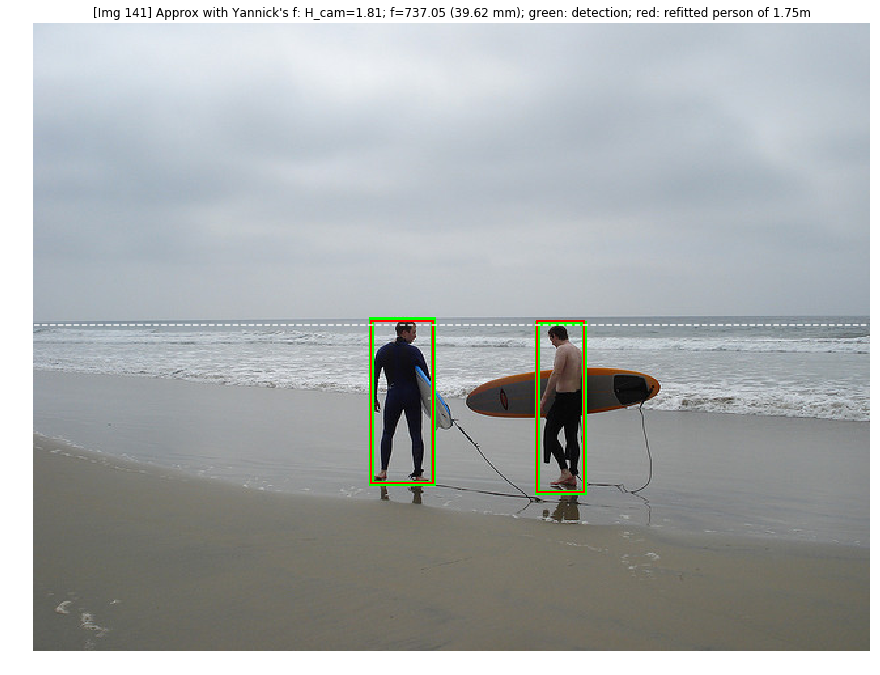

In [250]:
# horizon_midpoint = -horizon * 2. + 1.
# pitch = np.arctan(horizon_midpoint / (2 * f_pixels_yannick))
# print(pitch/np.pi*180.)

vfov = yannick_results['vfov'][0][0]
f_pixels_yannick = H/2./(np.tan(vfov/2.))

# f_pixels_yannick = fmm_to_fpix(50, H, W)

theta = (vc - v0) / f
theta_should = 2 * np.arctan((vc - v0) / (2. * f_pixels_yannick))
print('theta should be: %f; theta approx by Derek: %f'%(theta_should, theta))

inv_f2_yannick = 1./ (f_pixels_yannick * f_pixels_yannick)
# should_be_zero_yannick = (vc - v0) * (vc - vt) * inv_f2_yannick
# print('should_be_zero_yannick: %f'%should_be_zero_yannick)

H, W = I.shape[0], I.shape[1]
v0 = H - v0_image
y_person = 1.85
# yc = 1.6
vc = H / 2.

plt.figure(figsize=(15, 15))
ax = plt.gca()
plt.imshow(I)
plt.plot([0., W-1.], [v0_image, v0_image], 'w--', 'linewidth', 5)

yc_list = []
a_list = []
b_list = []
for bbox in bbox_good_list:
    vt = H - bbox[1]
    vb = H - (bbox[1] + bbox[3])
#     v0_single = yc * (vt - vb) / y_person + vb
    yc_single = y_person * (v0 - vb) / (vt - vb) / (1. + (vc - v0) * (vc - vt) / f_pixels_yannick**2)
    print('Cam height: ', yc_single)
    yc_list.append(yc_single)
    
    a = (vt - vb) / (v0 - vb)
    a_list.append(a)
    b = -y_person * (vc - v0) * (vc - vt)
    b_list.append(b)
    
yc_estCam = np.median(np.asarray(yc_list))
print('median_cam:', yc_estCam)
inv_f2 = 1. / (f_pixels_yannick*f_pixels_yannick)
f = f_pixels_yannick

should_be_zero = (vc - v0) * (vc - vt) * inv_f2
print('should_be_zero:', should_be_zero)

for bbox in bbox_good_list:
    rect = Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=5, edgecolor='lime', facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
    
#     vt = H - bbox[1]
    vb = H - (bbox[1] + bbox[3])
#     vt_camEst = y_person / yc_estCam * (v0 - vb) + vb
#     print(vt_camEst)
    vt_camEst = (yc_estCam * vb + y_person * (v0 - vb) * (1. + inv_f2 * (vc - v0) * vc)) / \
        (yc_estCam + y_person * (v0 - vb) * inv_f2 * (vc - v0))
    
    rect = Rectangle((bbox[0], H-vt_camEst), bbox[2], bbox[1]+bbox[3]-(H-vt_camEst), linewidth=2, edgecolor='r', facecolor='none')
#     # Add the patch to the Axes
    ax.add_patch(rect)

plt.title('[Img %d] Approx with Yannick\'s f: H_cam=%.2f; f=%.2f (%.2f mm); green: detection; red: refitted person of 1.75m'%(img_select, yc_estCam, f, f_to_mm(f, H, W)))
plt.axis('off')
plt.show()

In [5]:
def fpix_to_fmm(f, H, W):
    sensor_diag = 43 # full-frame sensor: 43mm
    img_diag = np.sqrt(H**2 + W**2)
    f_mm = f / img_diag * 43
    return f_mm

def fmm_to_fpix(f, H, W):
    sensor_diag = 43 # full-frame sensor: 43mm
    img_diag = np.sqrt(H**2 + W**2)
    f_pix = f / 43 * img_diag
    return f_pix

# functions

In [6]:
ann_kps = anns_kps[0]

def merge_bboxes(bboxes):
    max_x1y1x2y2 = [np.inf, np.inf, -np.inf, -np.inf]
    for bbox in bboxes:
        max_x1y1x2y2 = [min(max_x1y1x2y2[0], bbox[0]), min(max_x1y1x2y2[1], bbox[1]), 
                        max(max_x1y1x2y2[2], bbox[2]+bbox[0]), max(max_x1y1x2y2[3], bbox[3]+bbox[1])]
    return [max_x1y1x2y2[0], max_x1y1x2y2[1], max_x1y1x2y2[2]-max_x1y1x2y2[0], max_x1y1x2y2[3]-max_x1y1x2y2[1]]

def check_clear(ann, vis=False, debug=False):
    kps = np.asarray(ann['keypoints']).reshape(-1, 3)
    if debug:
        print(np.hstack((np.arange(kps.shape[0]).reshape((-1, 1)), kps)))
    
    if vis:
        plt.figure(figsize=(20, 20))
        plt.imshow(I); plt.axis('off')
        for idx, kp in enumerate(kps):
            plt.scatter(kp[0], kp[1], )
            plt.text(kp[0], kp[1], '%d'%idx, weight='bold')
            
    eyes_ys = kps[1:5, 1]
    eyes_ys_valid_idx = eyes_ys!=0
    eyes_ys_valid = eyes_ys[eyes_ys_valid_idx]
    ankles_ys = kps[15:17, 1]
    ankles_ys_valid_idx = ankles_ys!=0
    ankles_ys_valid = ankles_ys[ankles_ys_valid_idx]
    if eyes_ys_valid.size==0 or ankles_ys_valid.size==0:
        return False
    
    should_min_y_idx = np.argmin(eyes_ys_valid) # two eyes
    should_max_y_idx = np.argmax(ankles_ys_valid) # two ankles
    
    kps_valid = kps[kps[:, 1]!=0, :]
    
    if debug:
        print(eyes_ys_valid[should_min_y_idx], np.min(kps_valid[:, 1]), kps[15:17, 1][should_max_y_idx], np.max(kps_valid[:, 1]), kps[1:5, 2], kps[15:17, 2])
    
    return eyes_ys_valid[should_min_y_idx]==np.min(kps_valid[:, 1]) and ankles_ys_valid[should_max_y_idx]==np.max(kps_valid[:, 1]) \
        and np.any(np.logical_or(kps[1:5, 2]==1, kps[1:5, 2]==2)) and np.any(np.logical_or(kps[15:17, 2]==1, kps[15:17, 2]==2))

def check_valid_surface(cats):
    green_cats_exception = {'water':'', 'ground':'', 'solid':'', 'vegetation':['-', 'flower', 'tree'], 'floor':'', 'plant':['+', 'grass']}
    if_green = False
    for super_cat in green_cats_exception.keys():
        if cats[0] == super_cat:
            sub_cats = green_cats_exception[super_cat]
            if sub_cats == '':
                if_green = True
            elif sub_cats[0] == '-':
                if cats[1] not in sub_cats[1:]:
                    if_green = True
            elif sub_cats[0] == '+':
                if cats[1] in sub_cats[1:]:
                    if_green = True
    return if_green

# check_valid_surface(lower_left_id_subs)

# coco_kps.showAnns(anns_kps)
if_clear = check_clear(ann_kps, vis=True, debug=True)
coco_kps.showAnns([ann_kps])
print(if_clear)

[[  0   0   0   0]
 [  1   0   0   0]
 [  2   0   0   0]
 [  3   0   0   0]
 [  4   0   0   0]
 [  5 303 221   2]
 [  6 314 209   2]
 [  7 285 213   2]
 [  8 307 197   2]
 [  9 288 198   2]
 [ 10 292 190   2]
 [ 11 287 218   2]
 [ 12 297 208   2]
 [ 13 278 202   2]
 [ 14 302 190   2]
 [ 15 260 197   2]
 [ 16 285 180   2]]


NameError: global name 'I' is not defined

<Figure size 1440x1440 with 0 Axes>